So turns out tongue archives are stored as 256x256 which can be directly scaled on top of the video.

In [1]:
import sys
sys.path.append("/Users/eric/Workspace/wangLab/orofacial")

import orofacial

h5_path = "data/phox2b38_20240307_1_tongue.h5"

h5 = orofacial.tongue_mask_processing.TongueArchive(h5_path)
display(len(h5.frames))
display(h5.frames[0:5])



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


64645

array([4017, 4018, 4021, 4022, 4023])

100%|██████████| 64645/64645 [00:10<00:00, 6008.23it/s]


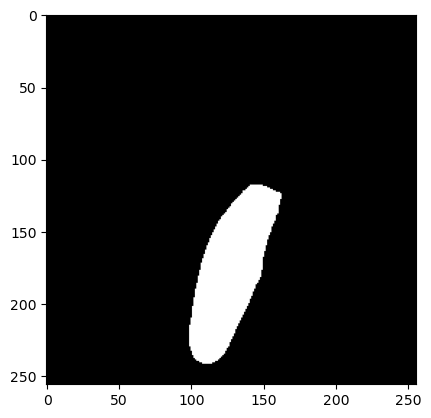

In [13]:
import tqdm
from matplotlib import pyplot as plt

imgs = []

for i in tqdm.tqdm(range(len(h5.frames))):
    imgs.append((orofacial.tongue_mask_processing.plot_frame_bool(h5, i, 256, 256), h5.frames[i]))

plt.imshow(imgs[29963][0], cmap='gray')

    

In [14]:
import numpy as np

# removing images with less than 15 pixels as preprocessing step
imgs = list(filter(lambda x : np.count_nonzero(x[0]) > 15, tqdm.tqdm(imgs)))

100%|██████████| 64645/64645 [00:00<00:00, 78489.09it/s]


In [15]:
imgs = list(map(lambda x : (orofacial.tongue_mask_processing.keep_largest_cc(x[0].astype(np.uint8)).astype(np.bool_), x[1]), tqdm.tqdm(imgs)))

100%|██████████| 60631/60631 [00:19<00:00, 3118.28it/s]


In [16]:
coords = list(map(lambda x : orofacial.tongue_tip_track_2D.find_tongue_tip(x[0], np.array([-1, 1], dtype=np.float32)), tqdm.tqdm(imgs)))

100%|██████████| 60631/60631 [01:27<00:00, 691.92it/s]


In [18]:

import matplotlib.pyplot as plt
import numpy as np

for i in range(len(coords)):
    if coords[i][0] < 50 or coords[i][1] < 90:
        plt.imsave(f"output/problem_tongue_{i}.png", imgs[i][0])

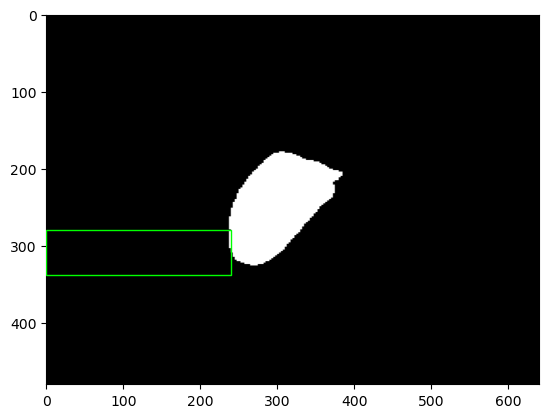

In [19]:
from matplotlib.patches import Rectangle

plt.imshow(imgs[29970][0], extent=[0, 640, 480, 0], cmap="gray")

def plot_feed_tube():
    plt.gca().add_patch(Rectangle((0,280),240,58,linewidth=1,edgecolor="#00FF00",facecolor='none', zorder=10))

plot_feed_tube()

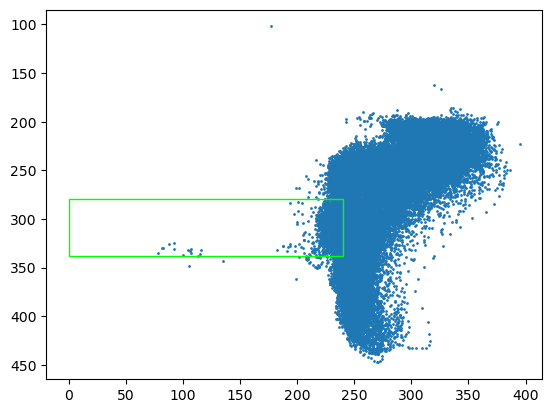

In [46]:
x, y = np.column_stack(coords)
plt.gca().invert_yaxis()
plot_feed_tube()
plt.scatter(x*(640/256), y*(480/256), s=1)


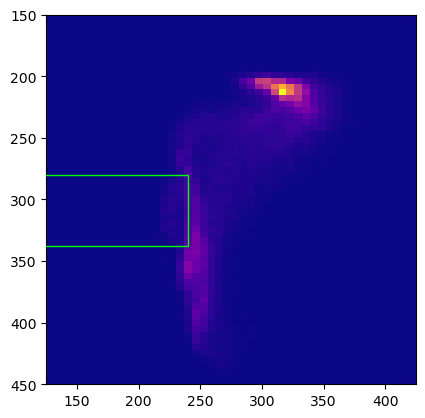

In [47]:
import matplotlib.pyplot as plt
import numpy as np
bad = 0

# heatmap
x, y = np.column_stack(coords)
heatmap, xedges, yedges = np.histogram2d(x, y, range=[[0, 256], [0, 256]], bins=(100, 100))

plt.clf()
plt.imshow(heatmap.T, extent=[0, 640, 480, 0], origin='upper', cmap="plasma")
plot_feed_tube()

def set_zoom():
    plt.gca().set_xlim([150, 400])
    plt.gca().set_ylim([450, 150])
    plt.gca().set_box_aspect(1)

set_zoom()
plt.show()



Assumption that each lick is separated by a consecutive window of empty frames

In [48]:
licks = [[coords[0]]]
for i in range(1, len(coords)):
    if isinstance(coords[i], np.ndarray):
        if imgs[i][1] != imgs[i-1][1] + 1:
            licks.append([coords[i]])
        else:
            licks[-1].append(coords[i])

len(licks)

3556

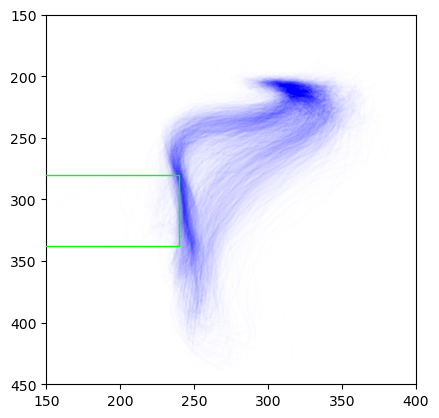

In [49]:
plt.gca().invert_yaxis()
for p in licks:
    x, y = np.column_stack(p)
    if len(x) > 4:
        plt.plot(x*(640/256), y*(480/256), alpha=0.005, c="blue")
plot_feed_tube()
set_zoom()
plt.show()

In [50]:
import os, subprocess, glob

def generate_video(img):
    for i in tqdm.tqdm(range(1000)):
         plt.clf()
         plt.imshow(img[i][0], cmap="gray")
         plt.scatter(x = coords[i][0], y = coords[i][1], c = "r", s = 10);
         plot_feed_tube()
         plt.savefig("file%02d.png" % i)

    os.chdir("output")
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name3.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)
    os.chdir("../")


### Averaging tongue trajectories

Each curve is defined as a sequence of $(x_1, y_1),\ldots$

First curves will be parametized with respect to arc length (euclidean distance)

Parametization will then be normalized such that $1$ is always the end of the curve, no matter which.

The final curve will be the average of all curves through enumeration of the arc length variable


In [51]:
import scipy

def interp(p):
    tck, u = scipy.interpolate.splprep(np.column_stack(p), s=0, k=3) 
    t = np.linspace(0, 1, 100)  # Get 100 interpolated points
    x_new, y_new = scipy.interpolate.splev(t, tck)
    # Resulting interpolated trajectory (list of tuples)
    return list(zip(x_new, y_new))

licks_p = []
for i in range(len(licks)):
    #splprep cannot handle duplicate points
    p = [licks[i][0]]
    for j in range(1, len(licks[i])):
        if np.linalg.norm(np.array(licks[i][j]) - np.array(p[-1])) > 0.001:
            p.append(licks[i][j])
    if len(p) > 3:
        licks_p.append(interp(p))

display(len(licks_p))

2602

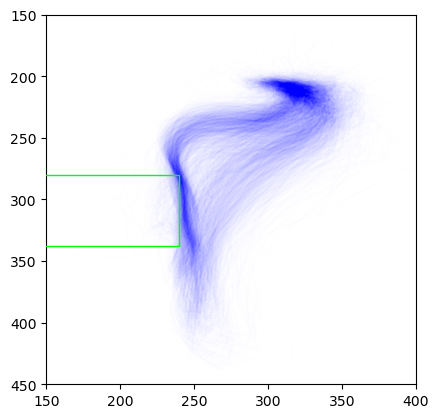

In [60]:
plt.gca().invert_yaxis()
for p in licks_p:
    x, y = np.column_stack(p)
    if len(x) > 4:
        plt.plot(x*(640/256), y*(480/256), alpha=0.005, c="blue")
plot_feed_tube()
set_zoom()
plt.show()

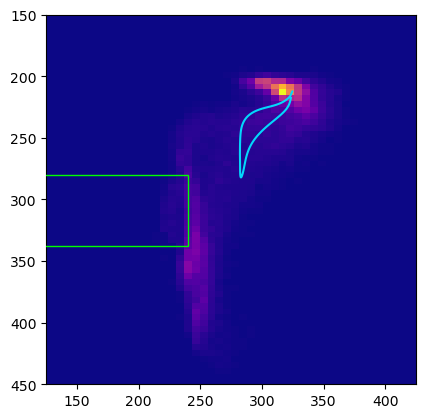

In [55]:
avg_p = np.mean(licks_p, axis=0)
plt.gca().invert_yaxis()
plot_feed_tube()
plt.plot(avg_p[:, 0]*(640/256), avg_p[:, 1]*(480/256), c="#03d7fc")
plt.imshow(heatmap.T, extent=[0, 640, 480, 0], origin='upper', cmap="plasma")
set_zoom()

1137

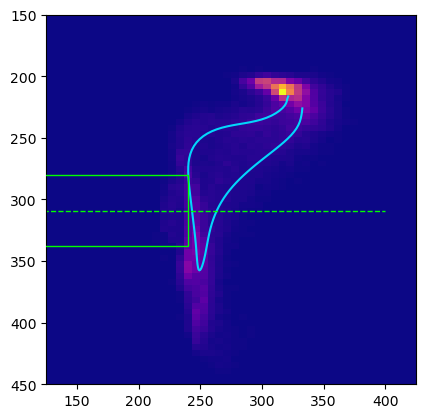

In [59]:
licks_p_big = [p for p in licks_p if max(np.column_stack(p)[1])>164]
display(len(licks_p_big))
avg_p = np.mean(licks_p_big, axis=0)
plt.gca().invert_yaxis()
#plt.axis('equal')
plot_feed_tube()
plt.plot(avg_p[:, 0]*(640/256), avg_p[:, 1]*(480/256), c="#03d7fc")
plt.imshow(heatmap.T, extent=[0, 640, 480, 0], origin='upper', cmap="plasma")
plt.plot([0, 400], [309, 309], "#00FF00", linewidth=1, linestyle="--")
set_zoom()
plt.show()